In [252]:
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns


In [253]:
data_users = pd.read_csv(r'\Users\Krzysztof.Kurek\Python Projects\Zadanie rekrutacyjne\data_users.csv')
data_ads = pd.read_csv(r'\Users\Krzysztof.Kurek\Python Projects\Zadanie rekrutacyjne\data_ads.csv')
data_visits = pd.read_csv(r'\Users\Krzysztof.Kurek\Python Projects\Zadanie rekrutacyjne\data_visits.csv')

In [254]:
print(f'data_users shape: {data_users.shape}')
print(f'data_ads shape: {data_ads.shape}')
print(f'data_visits shape: {data_visits.shape}')

data_users shape: (25152, 3)
data_ads shape: (30342, 3)
data_visits shape: (294839, 5)


# First Excerise - SQL Query

In [255]:
# First Excercise - SQL query 

sql = pd.DataFrame(sqldf(''' 
WITH users as (
SELECT DISTINCT(user_id), STRFTIME('%Y-%m-%d', time_stamp) as action_date
FROM data_visits
GROUP by user_id, action_date
Order by user_id desc, action_date asc),

user_start_date as (
Select user_id, action_date, MIN(action_date) OVER (PARTITION BY user_id) as start_date,
ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY action_date asc) as row_number
FROM users
ORDER BY user_id, action_date asc),

user_action_days as (SELECT *, JULIANDAY(action_date) - JULIANDAY(start_date) as days_since_start,
CASE WHEN start_date = action_date THEN 1 ELSE 0 END AS case_1
FROM user_start_date),

retention as (SELECT *, 
CASE 
    WHEN SUM(days_since_start) OVER (PARTITION BY user_id ORDER BY row_number ASC ROWS BETWEEN CURRENT ROW AND 3 FOLLOWING) BETWEEN 1 and 6 OR
        SUM(days_since_start) OVER (PARTITION BY user_id ORDER BY row_number ASC ROWS BETWEEN CURRENT ROW AND 2 FOLLOWING) BETWEEN 1 and 5 OR
        SUM(days_since_start) OVER (PARTITION BY user_id ORDER BY row_number ASC ROWS BETWEEN CURRENT ROW AND 1 FOLLOWING) BETWEEN 1 and 3
    THEN 1 ELSE 0 END as case_2
FROM user_action_days)

SELECT *,
CASE WHEN case_1 = 1 AND case_2 = 1 THEN 1 ELSE 0 END as retention
FROM retention'''))
     

In [256]:
# Calculate the retention rate on a given day

filtered_start_date = (sql['start_date'] >= '2021-06-01') & (sql['start_date'] <= '2021-06-07')

user_retention = sql[filtered_start_date].groupby('start_date').aggregate({
    'user_id': pd.Series.nunique,
    'retention': 'sum'
}).rename(columns={'user_id':'number of users'})

user_retention['% retention'] = round((user_retention['retention'] / user_retention['number of users']) * 100, 1)
user_retention.reset_index()

,start_date,number of users,retention,% retention
0,2021-06-01,932,655,70.3
1,2021-06-02,341,73,21.4
2,2021-06-03,303,37,12.2
3,2021-06-04,266,22,8.3
4,2021-06-05,294,16,5.4
5,2021-06-06,307,11,3.6
6,2021-06-07,316,17,5.4


In [257]:
# Average retention rate

avg_retention = user_retention.aggregate({
    '% retention': 'mean'  # Add this line to calculate the average rate
})

print(f' Average % retention rate from 1st of June to 7th of June is {avg_retention.round(1)}')

 Average % retention rate from 1st of June to 7th of June is % retention    18.1
dtype: float64


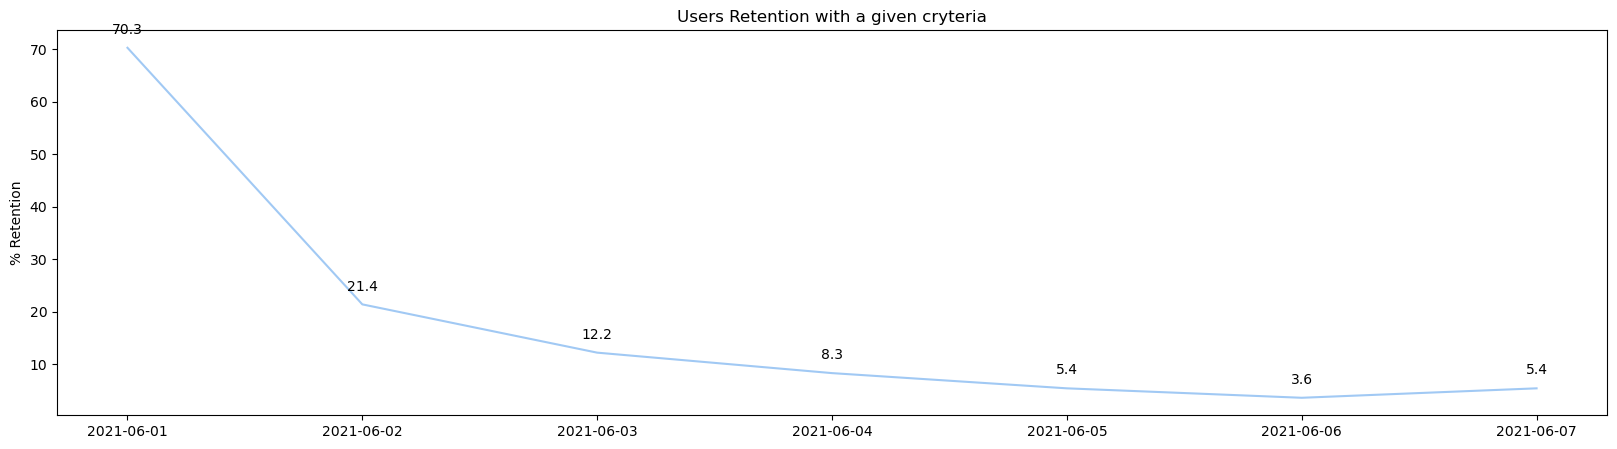

In [258]:
# Graph for the retention

plt.figure(figsize=(20, 5))
sns.lineplot(data=user_retention, x='start_date', y='% retention')

plt.title('Users Retention with a given cryteria')
plt.xlabel('')
plt.ylabel('% Retention')

# Add data labels
for index, row in user_retention.iterrows():
    plt.annotate(f'{row["% retention"]:.1f}', (index, row["% retention"]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()


In [259]:
# Sql query extraction to csv for data validation

sql.to_csv('sql.csv', sep=';')

## Add user status Active - Inactive based on retention analysis and it's assumptions

In [260]:
# Add user status Active - Inactive based on retention analysis and it's assumption

user_status_table = pd.DataFrame(sqldf('''SELECT DISTINCT(user_id), CASE WHEN sum(retention) OVER (PARTITION BY user_id) = 1 THEN "Active User" ELSE "Inactive User" END as user_status
FROM sql'''))
user_status_table

,user_id,user_status
0,007adox7c0wb,Inactive User
1,00gkhchnhmc3,Inactive User
2,01vjqcfu8ksb,Inactive User
3,021dyrc00ar6,Active User
4,02cdzysbuy98,Inactive User
...,...,...
3611,zx596nyhc2vp,Inactive User
3612,zxrkxhm6vo71,Active User
3613,zy9mq9dh60r0,Inactive User
3614,zz964g21ebma,Inactive User


Inactive User    2763
Active User       853
Name: user_status, dtype: int64


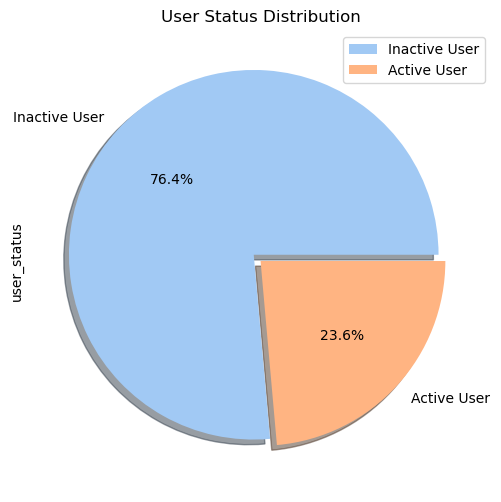

In [261]:
# User status distribution -  pie chart

colors = sns.color_palette('pastel')
plt.figure(figsize=(8,6))
user_status_table.user_status.value_counts().plot(kind='pie',explode=[0.05,0], shadow=True, autopct='%1.1f%%',
                           colors=colors)
plt.legend()
plt.title('User Status Distribution')
print(user_status_table.user_status.value_counts())

# EDA 

In [262]:
data_users.head()

,user_id,session_id,channel
0,g0sja4agdm0k,l2mu1asfx3gvbnxh,desktop_web
1,wdkg24pt65kz,jvd5mznecdykfu5g,mobile_web
2,alf0l68m8rhj,waezug10vuluzvjs,ios
3,rk9dm3ui88b4,1u2ux17lf85o17tu,android
4,mhvyh0179r16,hdykhjoykseotffn,mobile_web


In [263]:
data_ads.head()

,ad_id,category_name_1,category_name_2
0,85562364,Plots,Plots for Sale
1,12566559,Plots,Plots for Sale
2,4564313,Plots,Plots for Sale
3,22600229,Plots,Plots for Sale
4,75016268,Plots,Plots for Sale


In [264]:
data_visits.head()

,user_id,session_id,time_stamp,event_name,ad_id
0,g97t07v0wif2,ffa6acsavya608i3,2021-06-01 15:13:52,listing,NaN
1,5uhpyit6k11p,2vdknsqr0w4g8vkl,2021-06-07 10:15:54,listing,NaN
2,ouq25xxc0ey4,dpxkyy1bx9bff0si,2021-06-06 18:37:28,listing,NaN
3,696mc67vw4d4,6ggi8wvn27777s3l,2021-06-06 11:58:28,listing,NaN
4,t9fnztgbvj5d,9adjw1gu1fdk0bpf,2021-06-02 03:50:26,listing,NaN


In [265]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25152 entries, 0 to 25151
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     25152 non-null  object
 1   session_id  25152 non-null  object
 2   channel     25152 non-null  object
dtypes: object(3)
memory usage: 589.6+ KB


In [266]:
data_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30342 entries, 0 to 30341
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ad_id            30342 non-null  int64 
 1   category_name_1  30342 non-null  object
 2   category_name_2  30342 non-null  object
dtypes: int64(1), object(2)
memory usage: 711.3+ KB


In [267]:
data_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294839 entries, 0 to 294838
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     294839 non-null  object 
 1   session_id  294839 non-null  object 
 2   time_stamp  294839 non-null  object 
 3   event_name  294839 non-null  object 
 4   ad_id       104434 non-null  float64
dtypes: float64(1), object(4)
memory usage: 11.2+ MB


In [268]:
data_visits.nunique()

user_id         3616
session_id     25152
time_stamp    231369
event_name         2
ad_id          30336
dtype: int64

In [269]:
data_users.nunique()

user_id        3616
session_id    25152
channel           4
dtype: int64

In [270]:
data_ads.nunique()

ad_id              30337
category_name_1        6
category_name_2       11
dtype: int64

In [301]:
data_users.describe().T

,count,unique,top,freq
user_id,25152,3616,c9ozqmw0kp9n,86
session_id,25152,25152,l2mu1asfx3gvbnxh,1
channel,25152,4,android,15499


In [271]:
# Data transformation

data_visits['time_stamp'] = pd.to_datetime(data_visits['time_stamp'], format = '%Y.%m.%d %H:%M:%S')
data_visits['Date'] = data_visits['time_stamp'].dt.date

In [272]:
data_visits.info()
data_visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294839 entries, 0 to 294838
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     294839 non-null  object        
 1   session_id  294839 non-null  object        
 2   time_stamp  294839 non-null  datetime64[ns]
 3   event_name  294839 non-null  object        
 4   ad_id       104434 non-null  float64       
 5   Date        294839 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 13.5+ MB


,user_id,session_id,time_stamp,event_name,ad_id,Date
0,g97t07v0wif2,ffa6acsavya608i3,2021-06-01 15:13:52,listing,NaN,2021-06-01
1,5uhpyit6k11p,2vdknsqr0w4g8vkl,2021-06-07 10:15:54,listing,NaN,2021-06-07
2,ouq25xxc0ey4,dpxkyy1bx9bff0si,2021-06-06 18:37:28,listing,NaN,2021-06-06
3,696mc67vw4d4,6ggi8wvn27777s3l,2021-06-06 11:58:28,listing,NaN,2021-06-06
4,t9fnztgbvj5d,9adjw1gu1fdk0bpf,2021-06-02 03:50:26,listing,NaN,2021-06-02


# Channel Analysis

In [273]:
# Data prepration to analysis number of session devided by a channel 

users_session = data_users.groupby(['user_id','channel']).aggregate({'session_id': pd.Series.nunique}).reset_index()


android        1534
mobile_web     1012
ios             557
desktop_web     513
Name: channel, dtype: int64


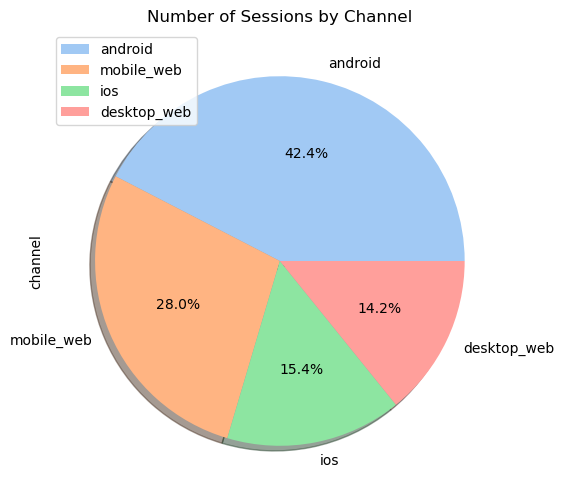

In [274]:
colors = sns.color_palette('pastel')
plt.figure(figsize=(8,6))
users_session.channel.value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%',
                           colors=colors)
plt.legend()
plt.title('Number of Sessions by Channel')
print(users_session.channel.value_counts())

In [275]:
# Table preparation for retention analysis devided by channel 

user_session_status = users_session.merge(user_status_table[['user_id','user_status']], on='user_id', how='left')
user_session_status_graph = user_session_status.groupby(['channel', 'user_status']).aggregate({'user_id': pd.Series.nunique}).reset_index()

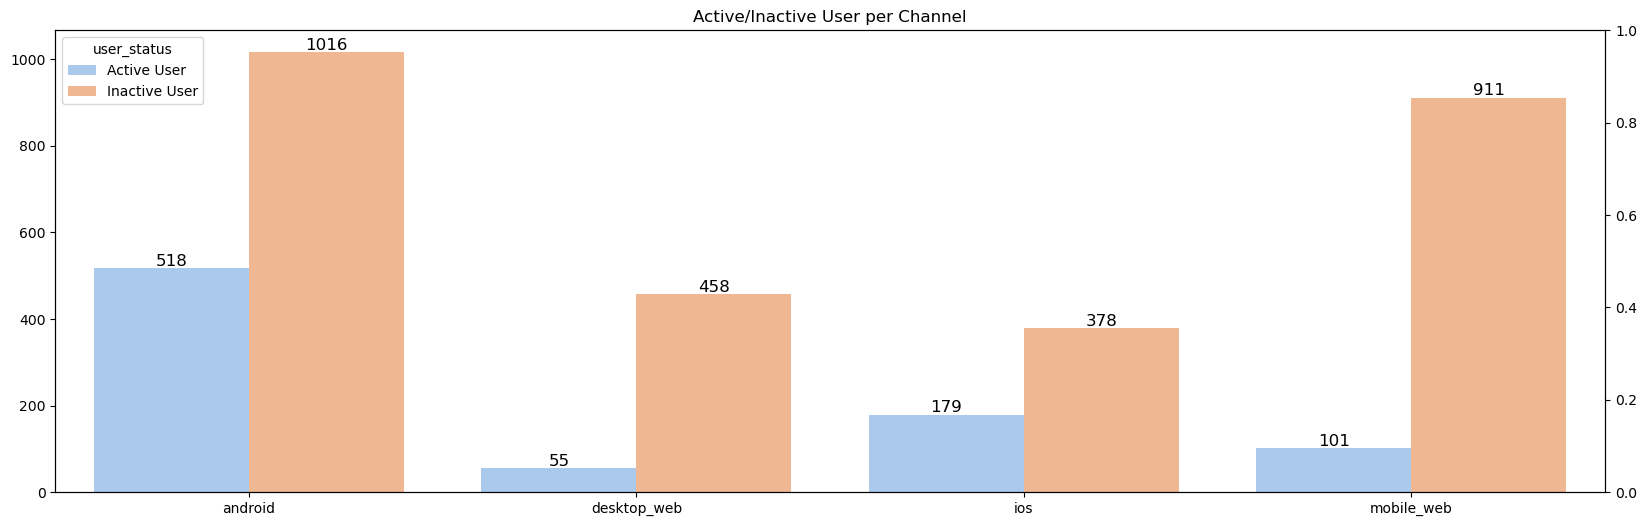

In [276]:
colors = sns.color_palette('pastel')

plt.figure(figsize=(20, 6))
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=user_session_status_graph, x='channel', y='user_id', hue='user_status')

# Add data labels to the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

ax2 = plt.twinx()
ax2.set_ylim(bottom=0, top=1)

ax.set_ylabel('')
ax.set_xlabel('')

plt.title('Active/Inactive User per Channel')
plt.show()


# Category 1 and Category 2 analysis

In [277]:
# Table preparation to analyse categories

big_table = data_visits[['user_id','session_id','event_name','ad_id']].merge(data_ads[['ad_id','category_name_1','category_name_2']], on='ad_id', how ='left').merge(user_status_table, on='user_id',how='left')
category_name_1_table = big_table.groupby(['category_name_1','user_status']).aggregate({'user_id': pd.Series.nunique}).reset_index()
category_name_2_table = big_table.groupby(['category_name_2','user_status']).aggregate({'user_id': pd.Series.nunique}).reset_index()

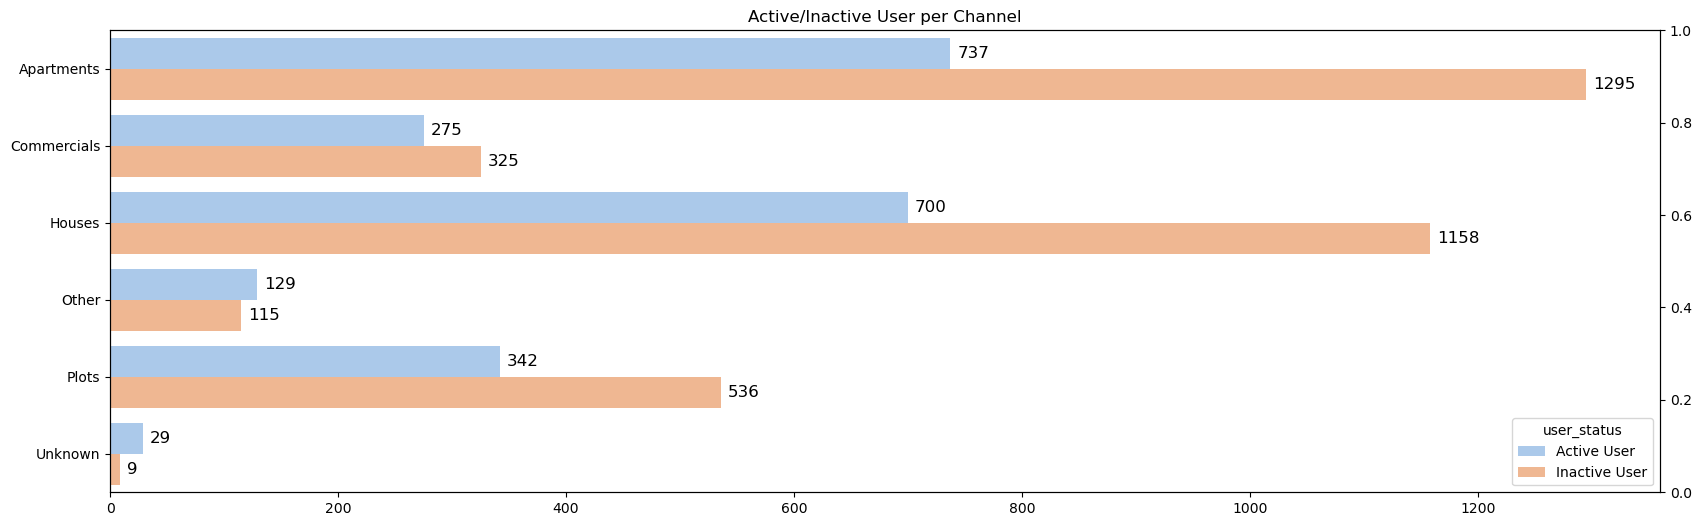

In [278]:
# Graph of category 1 distribution 

colors = sns.color_palette('pastel')

plt.figure(figsize=(20, 6))
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=category_name_1_table, x='user_id', y='category_name_1', hue='user_status')

# Add data labels to the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.), va='center', fontsize=12, color='black', xytext=(5, 0), textcoords='offset points')

ax2 = plt.twinx()
ax2.set_ylim(bottom=0, top=1)

ax.set_ylabel('')
ax.set_xlabel('')


plt.title('Active/Inactive User per Channel')
plt.show()

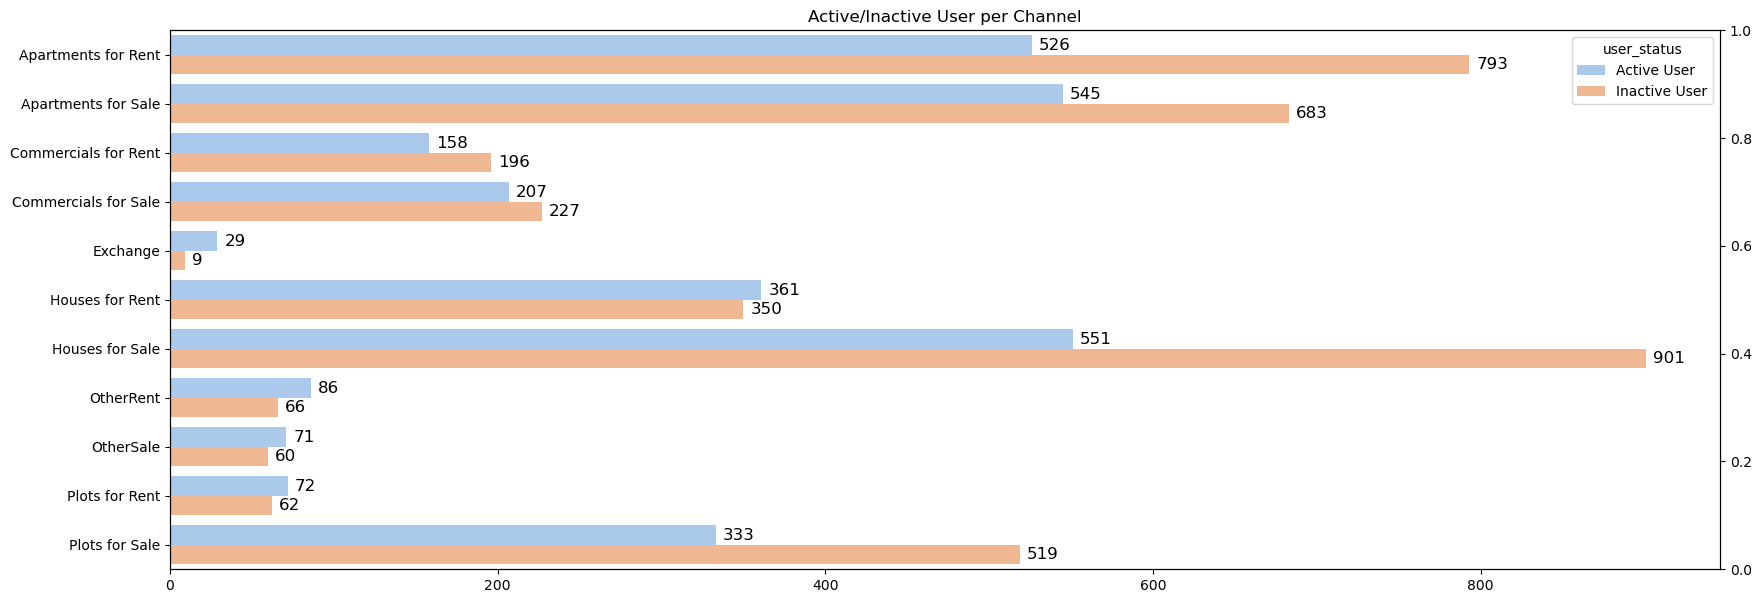

In [279]:
# Graph of category 2 distribution 


colors = sns.color_palette('pastel')

plt.figure(figsize=(20, 7))
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=category_name_2_table, x='user_id', y='category_name_2', hue='user_status')

# Add data labels to the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.), va='center', fontsize=12, color='black', xytext=(5, 0), textcoords='offset points')

ax2 = plt.twinx()
ax2.set_ylim(bottom=0, top=1)

ax.set_ylabel('')
ax.set_xlabel('')


plt.title('Active/Inactive User per Channel')
plt.show()

In [280]:
# Calculate how many categories each of the user viewed and devided it by their status

category_name_1_table = big_table.groupby(['user_id','user_status']).aggregate({'category_name_1':pd.Series.nunique}).reset_index()
category_name_1_table

,user_id,user_status,category_name_1
0,007adox7c0wb,Inactive User,1
1,00gkhchnhmc3,Inactive User,0
2,01vjqcfu8ksb,Inactive User,2
3,021dyrc00ar6,Active User,1
4,02cdzysbuy98,Inactive User,1
...,...,...,...
3611,zx596nyhc2vp,Inactive User,4
3612,zxrkxhm6vo71,Active User,3
3613,zy9mq9dh60r0,Inactive User,2
3614,zz964g21ebma,Inactive User,0


In [281]:
# Percentage distribution among users and categories_1 viewed 

category_1_users = category_name_1_table.groupby(['category_name_1']).aggregate({'user_id':pd.Series.nunique}).reset_index()
total_category_1_users = category_1_users['user_id'].sum()
category_1_users['% user_id'] = round((category_1_users['user_id'] / total_category_1_users) * 100, 1)
category_1_users

,category_name_1,user_id,% user_id
0,0,567,15.7
1,1,1527,42.2
2,2,853,23.6
3,3,351,9.7
4,4,235,6.5
5,5,74,2.0
6,6,9,0.2


In [282]:
avg_category_1 = category_name_1_table.aggregate({
    'category_name_1': 'mean'  # Add this line to calculate the average rate
})
avg_category_1

category_name_1    1.5625
dtype: float64

Text(0, 0.5, 'Number of Users')

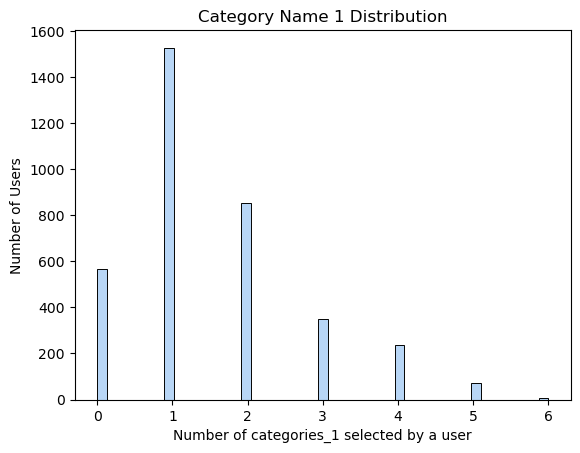

In [283]:
# Histogram of category 1

sns.histplot(data=category_name_1_table, x="category_name_1")

plt.title('Category Name 1 Distribution')
plt.xlabel('Number of categories_1 selected by a user')
plt.ylabel('Number of Users')

In [284]:
# Percentage distribution among users and categories_2 viewed 

category_2_users = category_name_2_table.groupby(['category_name_2']).aggregate({'user_id':pd.Series.nunique}).reset_index()
total_category_2_users = category_2_users['user_id'].sum()
category_2_users['% user_id'] = round((category_2_users['user_id'] / total_category_2_users) * 100, 1)
category_2_users

,category_name_2,user_id,% user_id
0,Apartments for Rent,2,9.1
1,Apartments for Sale,2,9.1
2,Commercials for Rent,2,9.1
3,Commercials for Sale,2,9.1
4,Exchange,2,9.1
5,Houses for Rent,2,9.1
6,Houses for Sale,2,9.1
7,OtherRent,2,9.1
8,OtherSale,2,9.1
9,Plots for Rent,2,9.1


<Axes: xlabel='category_name_2', ylabel='Count'>

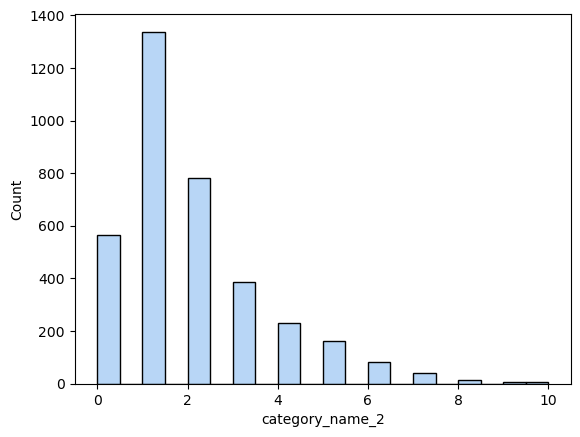

In [285]:
# Histogram of category 2 

category_name_2_table = big_table.groupby(['user_id','user_status']).aggregate({'category_name_2':pd.Series.nunique}).reset_index()
sns.histplot(data=category_name_2_table, x="category_name_2", binwidth = 0.5)

# Retention based on categories viewed by a user

In [286]:
# Filter onlny users who visited 1 category

category_name_1_table_filtered = category_name_1_table[category_name_1_table['category_name_1'] == 1]

category_name_1_table_filtered.reset_index()

,index,user_id,user_status,category_name_1
0,0,007adox7c0wb,Inactive User,1
1,3,021dyrc00ar6,Active User,1
2,4,02cdzysbuy98,Inactive User,1
3,5,02ene2z4rs2b,Inactive User,1
4,6,02wcuvx8dvvc,Inactive User,1
...,...,...,...,...
1522,3605,zvv04uqozoqz,Inactive User,1
1523,3606,zvvw7x6ivudv,Inactive User,1
1524,3607,zvwirdkc44hv,Inactive User,1
1525,3608,zwdpn70qigo5,Inactive User,1


In [287]:
# Retention table prepration for users who viewed onlny 1 category

user_with_1_category_retention = category_name_1_table_filtered[['user_id']].merge(sql[['user_id','start_date','retention']], on='user_id', how='left').reset_index()
user_with_1_category_retention

,index,user_id,start_date,retention
0,0,007adox7c0wb,2021-06-02,0
1,1,021dyrc00ar6,2021-06-01,1
2,2,021dyrc00ar6,2021-06-01,0
3,3,021dyrc00ar6,2021-06-01,0
4,4,021dyrc00ar6,2021-06-01,0
...,...,...,...,...
2430,2430,zvv04uqozoqz,2021-06-04,0
2431,2431,zvvw7x6ivudv,2021-06-05,0
2432,2432,zvwirdkc44hv,2021-06-06,0
2433,2433,zwdpn70qigo5,2021-06-02,0


In [288]:
# Summarised retention table for users who viewed onlny 1 category

user_with_1_category_retention = user_with_1_category_retention.groupby('start_date').aggregate({
    'user_id': pd.Series.nunique,
    'retention': 'sum'
})

user_with_1_category_retention['% retention'] = round((user_with_1_category_retention['retention'] / user_with_1_category_retention['user_id']) * 100, 1)
user_with_1_category_retention.reset_index()

,start_date,user_id,retention,% retention
0,2021-06-01,232,97,41.8
1,2021-06-02,173,15,8.7
2,2021-06-03,129,8,6.2
3,2021-06-04,122,8,6.6
4,2021-06-05,151,10,6.6
5,2021-06-06,145,3,2.1
6,2021-06-07,141,6,4.3
7,2021-06-08,157,3,1.9
8,2021-06-09,132,2,1.5
9,2021-06-10,142,4,2.8


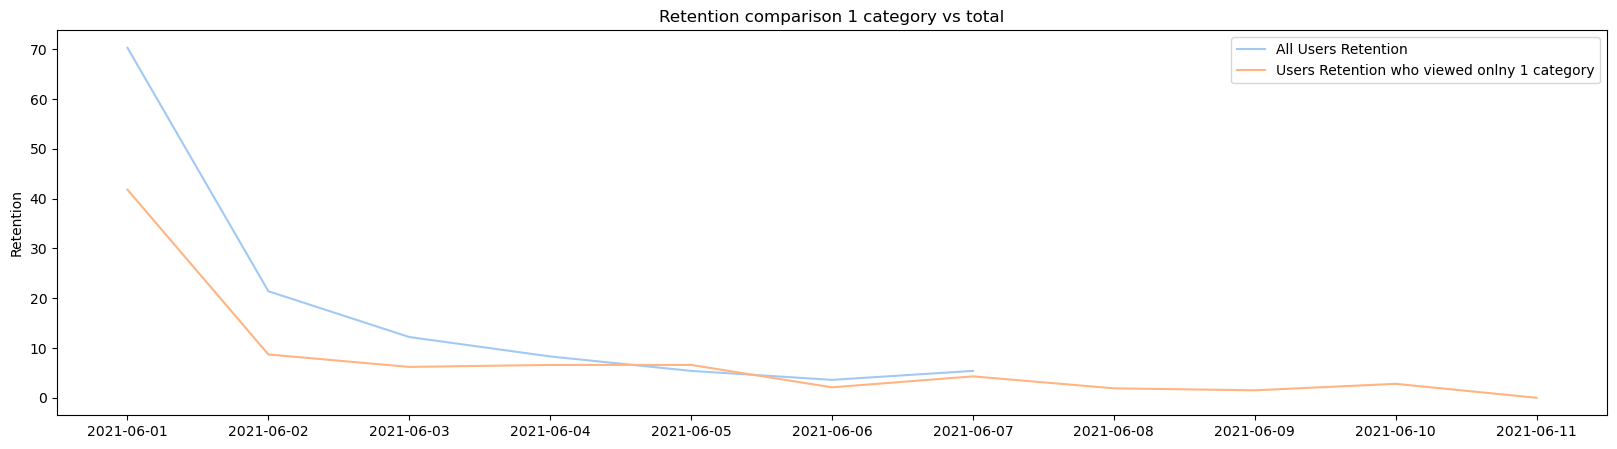

In [289]:
# Graph for the retention users who viewed onlny 1 category

plt.figure(figsize=(20, 5))
sns.lineplot(data=user_retention, x='start_date', y='% retention', label='All Users Retention')
sns.lineplot(data=user_with_1_category_retention, x='start_date', y='% retention', label='Users Retention who viewed onlny 1 category')

plt.title('Retention comparison 1 category vs total')
plt.xlabel('')
plt.ylabel('Retention')
plt.show()

In [290]:
# Table preparation to analyse retention among all the users including different number of categories viewed

user_based_on_categories_retention = category_name_1_table[['user_id','category_name_1']].merge(sql[['user_id','start_date','retention']], on='user_id', how='left').reset_index()
user_based_on_categories_retention

,index,user_id,category_name_1,start_date,retention
0,0,007adox7c0wb,1,2021-06-02,0
1,1,00gkhchnhmc3,0,2021-06-03,0
2,2,01vjqcfu8ksb,2,2021-06-01,0
3,3,021dyrc00ar6,1,2021-06-01,1
4,4,021dyrc00ar6,1,2021-06-01,0
...,...,...,...,...,...
9716,9716,zzj8mxoqnmp3,2,2021-06-01,0
9717,9717,zzj8mxoqnmp3,2,2021-06-01,0
9718,9718,zzj8mxoqnmp3,2,2021-06-01,0
9719,9719,zzj8mxoqnmp3,2,2021-06-01,0


In [291]:
# Summarised table of users retention and number of categories viewed

filtered_date = (user_based_on_categories_retention['start_date'] >= '2021-06-01') & (user_based_on_categories_retention['start_date'] <= '2021-06-04')

user_with_all_category_retention = user_based_on_categories_retention[filtered_date].groupby(['start_date','category_name_1']).aggregate({
    'user_id': pd.Series.nunique,''
    'retention': 'sum'
})
user_with_all_category_retention= pd.DataFrame(user_with_all_category_retention).reset_index()
user_with_all_category_retention

,start_date,category_name_1,user_id,retention
0,2021-06-01,0,52,5
1,2021-06-01,1,232,97
2,2021-06-01,2,282,216
3,2021-06-01,3,171,155
4,2021-06-01,4,139,129
5,2021-06-01,5,48,45
6,2021-06-01,6,8,8
7,2021-06-02,0,49,1
8,2021-06-02,1,173,15
9,2021-06-02,2,81,31


C:\Users\Krzysztof.Kurek\AppData\Local\Temp\9\ipykernel_29140\4151479350.py:6: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=user_with_all_category_retention, x='start_date', y='retention', hue='category_name_1',


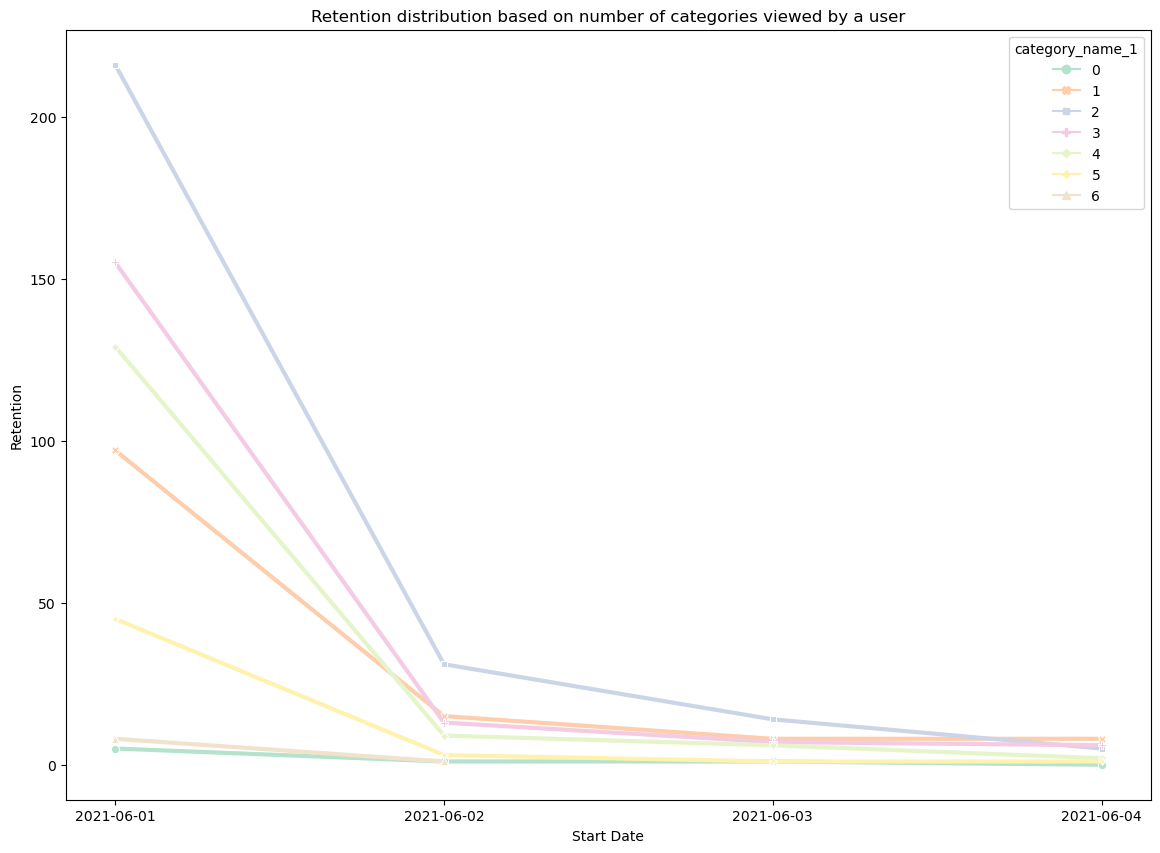

In [292]:
# Final retention graph divided by the number of category_1 viewed by a users

palette2 = sns.color_palette('Pastel2')

plt.figure(figsize=(14, 10))
sns.lineplot(data=user_with_all_category_retention, x='start_date', y='retention', hue='category_name_1', 
             palette=palette2, markers=True, dashes=False, style='category_name_1', linewidth=3)

plt.title('Retention distribution based on number of categories viewed by a user')
plt.xlabel('Start Date')
plt.ylabel('Retention')
plt.show()

# Correlation between category_1 and category_2 and retention

In [293]:
# specified categories for category_name_1

big_table['category_name_1'].unique()

array([nan, 'Houses', 'Other', 'Apartments', 'Plots', 'Commercials',
       'Unknown'], dtype=object)

In [294]:
# specified categories for category_name_2

big_table['category_name_2'].unique()

array([nan, 'Houses for Rent', 'Houses for Sale', 'OtherSale',
       'Apartments for Rent', 'Apartments for Sale', 'Plots for Sale',
       'Commercials for Rent', 'OtherRent', 'Commercials for Sale',
       'Exchange', 'Plots for Rent'], dtype=object)

In [295]:
# Category_name_1 transformation - dummies

category_name_1_transformation = big_table[['category_name_1','user_status']]
category_name_1_transformation = pd.get_dummies(data=category_name_1_transformation,columns=['category_name_1','user_status'])

<Axes: >

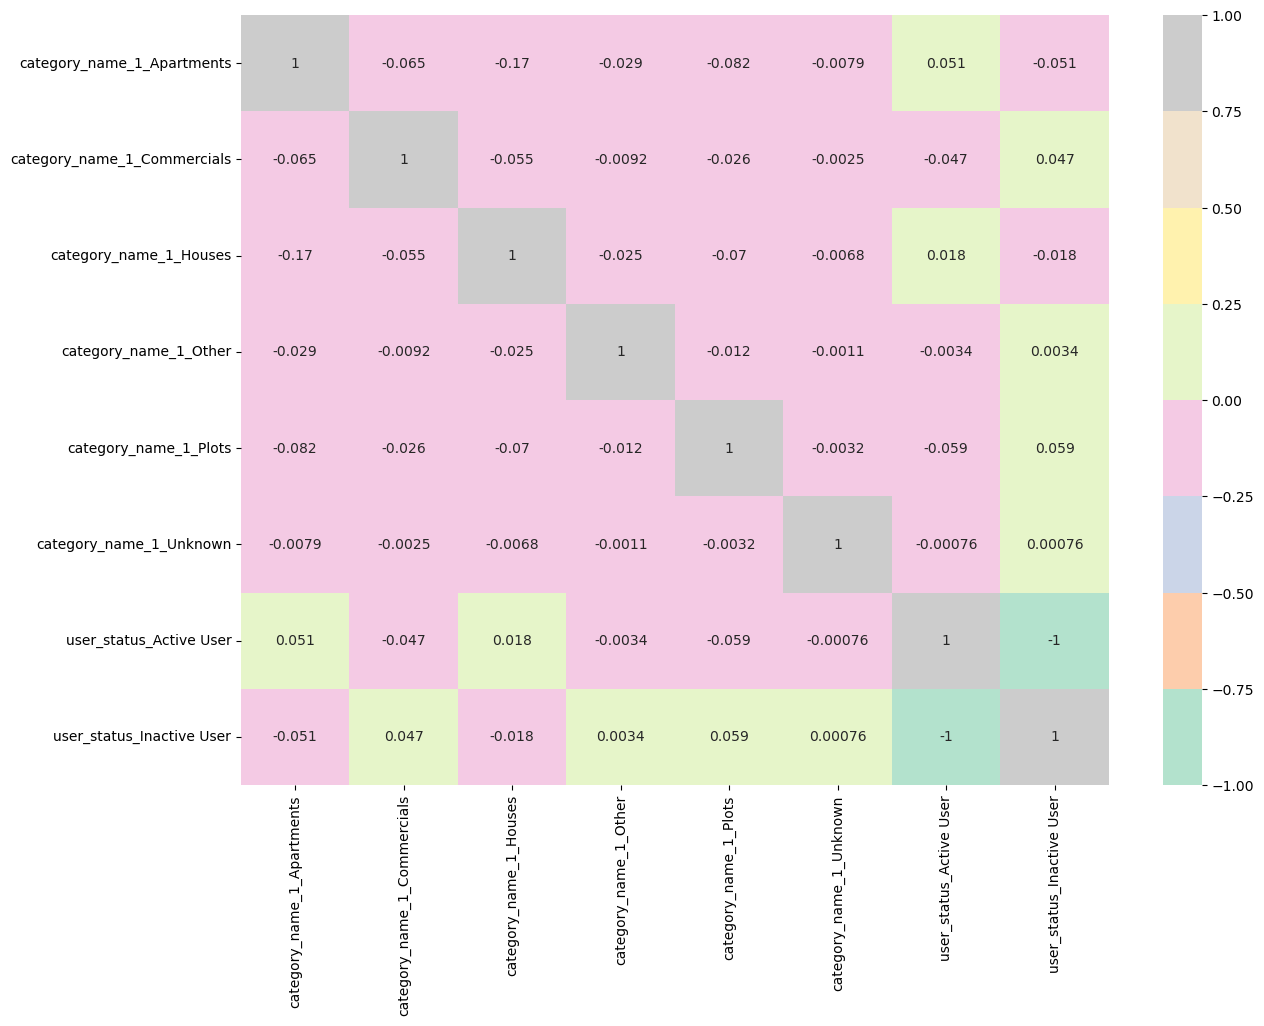

In [296]:
# Correlation matrix for category_name_1

plt.figure(figsize=(14,10))
df_cor = category_name_1_transformation.corr().T
sns.heatmap(data=df_cor, annot=True, cmap='Pastel2')

In [297]:
# Category_name_2 transformation - dummies

category_name_2_transformation = big_table[['category_name_2','user_status']]
category_name_2_transformation = pd.get_dummies(data=category_name_2_transformation,columns=['category_name_2','user_status'])

<Axes: >

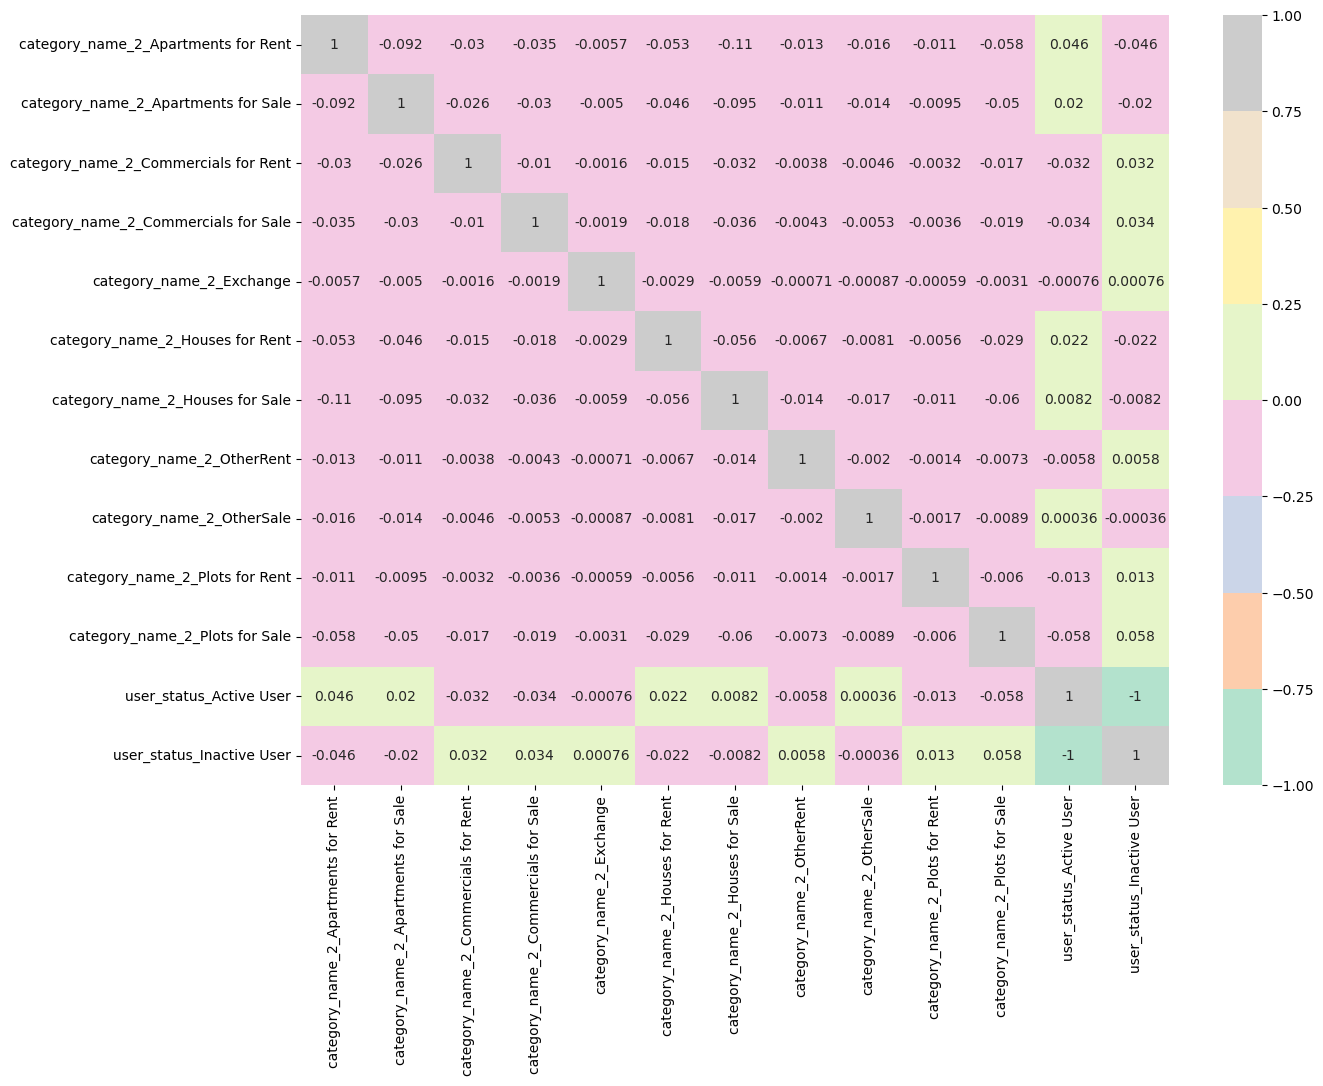

In [298]:
# Correlation matrix for category_name_2

plt.figure(figsize=(14,10))
df_cor = category_name_2_transformation.corr().T
sns.heatmap(data=df_cor, annot=True, cmap='Pastel2')

In [299]:
# table preparation to analyse retention rate over the channels

ios_vs_android = sql[['user_id','start_date','retention']].merge(data_users[['channel','user_id']], on ='user_id', how ='left').merge(user_status_table[['user_status','user_id']], on ='user_id', how ='left')

filtered_date = (ios_vs_android['start_date'] >= '2021-06-01') & (ios_vs_android['start_date'] <= '2021-06-04')

ios_vs_android = ios_vs_android[filtered_date].groupby(['start_date','channel']).aggregate({
    'user_id': pd.Series.nunique,''
    'retention': 'sum'
})
ios_vs_android= pd.DataFrame(ios_vs_android).reset_index()
ios_vs_android.head()

,start_date,channel,user_id,retention
0,2021-06-01,android,537,12810
1,2021-06-01,desktop_web,95,1141
2,2021-06-01,ios,156,3797
3,2021-06-01,mobile_web,144,1850
4,2021-06-02,android,142,923


C:\Users\Krzysztof.Kurek\AppData\Local\Temp\9\ipykernel_29140\2519000718.py:4: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.lineplot(data=ios_vs_android, x='start_date', y='retention', hue='channel', palette=palette2, markers=True, dashes=False,


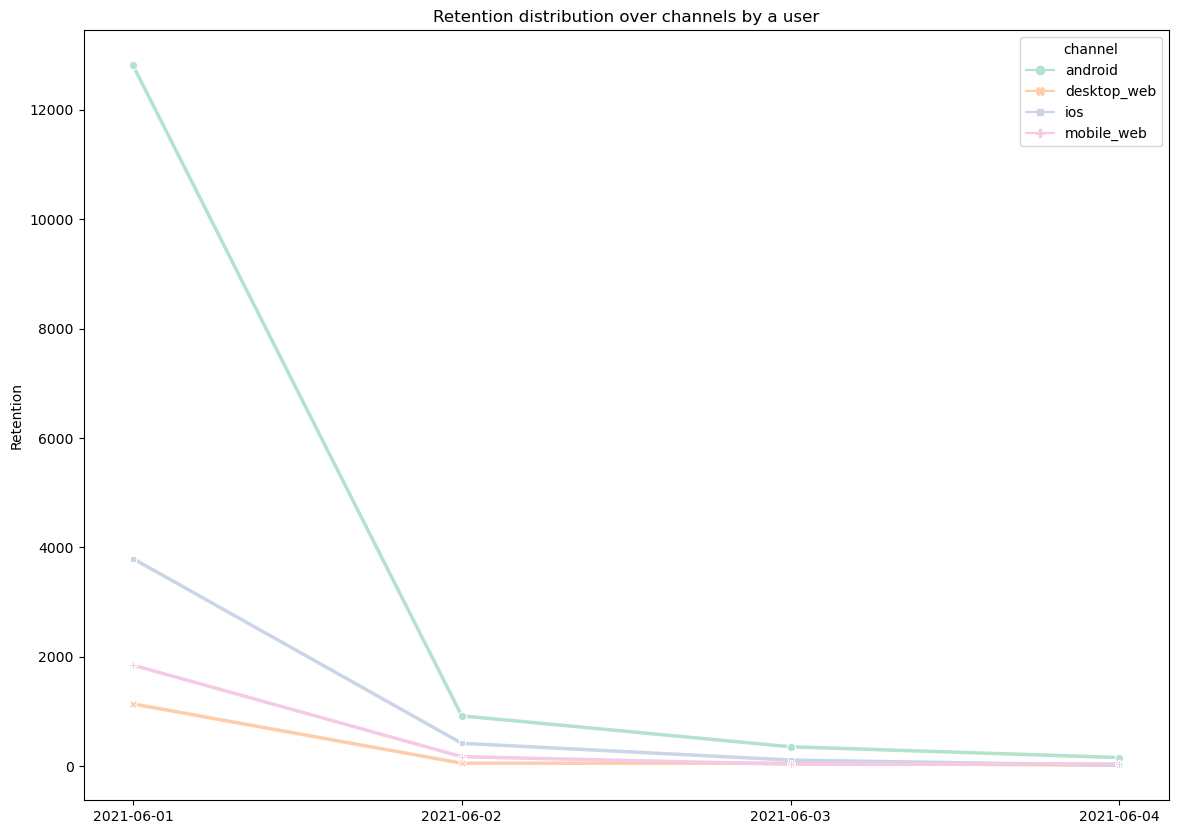

In [300]:
# Retention graph for retention by channels

plt.figure(figsize=(14, 10))
sns.lineplot(data=ios_vs_android, x='start_date', y='retention', hue='channel', palette=palette2, markers=True, dashes=False, 
             style='channel', linewidth=2.5)

plt.title('Retention distribution over channels by a user')
plt.xlabel('')
plt.ylabel('Retention')
plt.show()